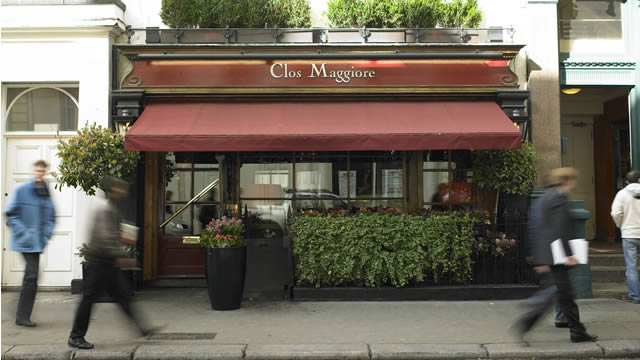

# Jean-Claude's London Restaurant
### IBM Data Science Professional Certificate Capstone Project

## Introduction/Business Problem
In this project I will be working on behalf of my friend Jean-Claude who is looking to open an upmarket French restaurant in London. He has visited London a few times but he does not know it well and is unsure of where exactly he might open the restaurant. He really cares about this work because regardless of the quality of the food and service, the success or failure of this restaurant could hinge on the appropriate selection of a location.

London is split into hundreds of neighborhoods called 'wards'. The term 'ward' is predominantly used in the context of elections, but the even in day-to-day language, areas of London are typically referred to by the name of the ward.

## Data

Venue data from Foursquare will be merged with London ward and income data available from the link below. I hope to be able to find a few suitable wards where Jean-Claude might look to open a restaurant, based on the criteria discussed in the methodology section.

#### Doogal
- The Doogal dataset contains a wealth of high resolution data about London and its inhabitants
    - Income by postcode
    - Physical location of each postcode
    - Population of each postcode
    - Number of households in each postcode
    - Level of deprivation (an aggregate of several other factors including crime)

https://www.doogal.co.uk/UKPostcodesCSV.ashx?area=London

#### Foursquare
- Foursquare has data on venues across the world, but of particular utility in this project will be:
    - Physical location of venues in London, including restaurants.
    - Category data for each venue.



## Methodology

#### Description

Jean-Claude is an experienced restauranteur and he has a good appreciation of the principles by which the location of a new restaurant should be selected. In this case, the restaurant will be a high-class, fine dining restaurant, his principles for this opening are to:
- Rule out the wards without any restaurants to avoid industrial areas etc.
- Rule out the areas with an existing French restaurant to minimise direct local competition.
- Rank the remaining areas by the income of residents and visualise this information

Since this is not particularly sophisticated, a subsequent analysis will then be done to try to identify wards which might support a larger number of French restaurants than are presently established. A model will be built based on the available data to find wards where French restaurants are under-represented. The predictions of this model will then be compared with the actual number of restaurants in order to find gaps in the market. Ultimately, this might save Jean-Claude the unnecessary expense in the cost of rent by allowing him to select a more affordable area and still find sufficient clientele.

#### Load and clean London data from Doogal

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns; sns.set()
import requests
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

print('Libraries imported.')

Libraries imported.


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Read data on London postcodes into dataframe

In [29]:
dfLondon = pd.read_csv('londonPostcodes.csv', low_memory=False)

TypeError: 'tuple' object is not callable

In [30]:
dfLondon.shape

(323306, 49)

Select only columns useful for this study and apply code-friendly column labels

In [3]:
columns = ['Postcode','In Use?','Latitude','Longitude','District','Ward','Constituency','Population','Households','London zone','Index of Multiple Deprivation','Postcode area','Postcode district','Average Income','Travel To Work Area']
dfLondon = dfLondon[columns].copy()
dfLondon.columns = ['postcode','active','lat','long','district','ward','constituency','population','households','travelZone','deprivation','postcodeArea','postcodeDistrict','income','workTravelArea']

Drop inactive postcodes

In [4]:
dfLondon = dfLondon.drop(dfLondon[dfLondon.active == 'No'].index)

Drop the outer regions of London

In [5]:
londonPostcodeAreas = ['N','E','S','W','SE','SW','NW','EC','WC']
dfLondon = dfLondon[dfLondon['postcodeArea'].isin(londonPostcodeAreas)]

Replace NaN values for population and households in each postcode by the average of the postcodeDistrict, then - if still NaN - the average of the postcodeArea. Convert floats to integers.

In [6]:
dfLondon['population'].fillna(dfLondon.groupby(['postcodeDistrict'])['population'].transform(np.mean), inplace=True)
dfLondon['population'].fillna(dfLondon.groupby(['postcodeArea'])['population'].transform(np.mean), inplace=True)
dfLondon['population'] = dfLondon['population'].astype(int)

dfLondon['households'].fillna(dfLondon.groupby(['postcodeDistrict'])['households'].transform(np.mean), inplace=True)
dfLondon['households'].fillna(dfLondon.groupby(['postcodeArea'])['households'].transform(np.mean), inplace=True)
dfLondon['households'] = dfLondon['households'].astype(int)

Create new column for whether the area is in central London ('EC' or 'WC' postcode Area)

In [7]:
def central(df):
    if df['postcodeArea'] == 'EC': return 1
    elif df['postcodeArea'] == 'WC': return 1
    else: return 0
dfLondon['central'] = dfLondon.apply(central, axis=1)

Create new column for the distance from the centre of London

In [8]:
def distanceFromCentre(df):
    londonLat = 51.5074
    londonLong = -0.1278
    latDistance = (df['lat'] - londonLat)*111
    longDistance = (df['long'] - londonLong)*111
    distance = (latDistance**2 + longDistance**2)**0.5
    return distance
dfLondon['distanceFromCentre'] = dfLondon.apply(distanceFromCentre, axis=1)

Sum the population and household data

In [9]:
dfLondonSums = dfLondon.groupby(['ward']).sum()
dfLondonSums = dfLondonSums[['population','households']]
dfLondonSums.reset_index()

,ward,population,households
0,Abbey,12410,5420
1,Abbey Road,12233,5684
2,Abbey Wood,16900,6414
3,Abingdon,15368,7314
4,Acton Central,16744,6794
...,...,...,...
418,Woodhouse,19391,7606
419,Woodside,30426,12260
420,Woolwich Common,20997,7673
421,Woolwich Riverside,28080,11580


Average the location, deprivation, income, and distance data

In [10]:
dfLondonMeans = dfLondon.groupby(['ward']).mean()
dfLondonMeans.reset_index(inplace=True)
dfLondonMeans.drop(columns=['population','households'], inplace=True)

In [11]:
dfLondonGrouped = pd.merge(
    left=dfLondonMeans,
    right=dfLondonSums,
    how="inner",
    left_on='ward',
    right_on='ward',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
dfLondonGrouped

,ward,lat,long,travelZone,deprivation,income,central,distanceFromCentre,population,households
0,Abbey,51.415388,-0.191446,3.000000,23214.726457,67604.484305,0.0,12.428878,12410,5420
1,Abbey Road,51.534390,-0.178128,2.000000,24245.784615,58690.769231,0.0,6.351327,12233,5684
2,Abbey Wood,51.490913,0.113503,4.000000,8798.677778,44015.555556,0.0,26.851004,16900,6414
3,Abingdon,51.497363,-0.196452,1.072508,22261.413897,66328.700906,0.0,7.703365,15368,7314
4,Acton Central,51.513184,-0.269343,2.561594,12456.278986,51644.565217,0.0,15.730607,16744,6794
...,...,...,...,...,...,...,...,...,...,...
418,Woodhouse,51.612978,-0.173001,4.000000,18569.039474,52204.210526,0.0,12.765412,19391,7606
419,Woodside,51.503020,-0.087501,3.149533,9868.406542,47891.355140,0.0,12.427954,30426,12260
420,Woolwich Common,51.482850,0.066809,3.942122,7432.482315,42756.270096,0.0,21.778642,20997,7673
421,Woolwich Riverside,51.491161,0.057412,3.377828,10840.778281,49269.230769,0.0,20.639791,28080,11580


Normalise the data for subsequent analysis

In [12]:
dfLondonNorm = dfLondonGrouped
dfLondonNorm['population'] = dfLondonNorm['population']/dfLondonNorm['population'].max()
dfLondonNorm['households'] = dfLondonNorm['households']/dfLondonNorm['households'].max()
dfLondonNorm['deprivation'] = dfLondonNorm['deprivation']/dfLondonNorm['deprivation'].max()
dfLondonNorm['income'] = dfLondonNorm['income']/dfLondonNorm['income'].max()
dfLondonNorm['distanceFromCentre'] = dfLondonNorm['distanceFromCentre']/dfLondonNorm['distanceFromCentre'].max()
dfLondonNorm['travelZone'] = dfLondonNorm['travelZone']/dfLondonNorm['travelZone'].max()
dfLondonNorm

,ward,lat,long,travelZone,deprivation,income,central,distanceFromCentre,population,households
0,Abbey,51.415388,-0.191446,0.545455,0.777933,0.876389,0.0,0.435930,0.128819,0.135799
1,Abbey Road,51.534390,-0.178128,0.363636,0.812484,0.760837,0.0,0.222766,0.126981,0.142413
2,Abbey Wood,51.490913,0.113503,0.727273,0.294847,0.570595,0.0,0.941772,0.175426,0.160704
3,Abingdon,51.497363,-0.196452,0.195001,0.745987,0.859851,0.0,0.270188,0.159523,0.183253
4,Acton Central,51.513184,-0.269343,0.465744,0.417414,0.669493,0.0,0.551735,0.173807,0.170224
...,...,...,...,...,...,...,...,...,...,...
418,Woodhouse,51.612978,-0.173001,0.727273,0.622255,0.676748,0.0,0.447734,0.201283,0.190569
419,Woodside,51.503020,-0.087501,0.572642,0.330693,0.620839,0.0,0.435898,0.315829,0.307176
420,Woolwich Common,51.482850,0.066809,0.716749,0.249065,0.554270,0.0,0.763864,0.217954,0.192248
421,Woolwich Riverside,51.491161,0.057412,0.614151,0.363278,0.638701,0.0,0.723920,0.291477,0.290138


#### Load venue data from FourSquare

In [13]:
CLIENT_ID = '########' #FourSquare user
CLIENT_SECRET = '#######' #FourSquare ID pass
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [14]:
def getNearbyVenues(wards, latitudes, longitudes, central):
    
    venues_list=[]
    for name, lat, lng, central in zip(wards, latitudes, longitudes, central):
        # account for higher density of wards within central London
        if central==1:
            radius=500
        else:
            radius=1000
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ward', 
                  'wardLat', 
                  'wardLong', 
                  'venue', 
                  'venueLat', 
                  'venueLong', 
                  'venueCat']
    
    return(nearby_venues)

Comment out the function call to limit calls on the API

In [15]:
# dfVenues = getNearbyVenues(wards=dfLondonGrouped['ward'],
#                                   latitudes=dfLondonGrouped['lat'],
#                                   longitudes=dfLondonGrouped['long'],
#                                   central=dfLondonGrouped['central']
#                                  )
# dfVenues

Locally store a copy of the API call data

In [16]:
# dfVenues.to_csv('dfVenues.csv')
# Saved local copy of dfVenues to reduce API calls during testing.

dfVenues = pd.read_csv('dfVenues2.csv')
dfVenues = dfVenues.drop('Unnamed: 0', axis=1)

In [31]:
dfVenues.shape

(25658, 11)

Identify key amenities: restaurants, parks, shops

In [17]:
def restaurant(df):
    if df['venueCat'][-10:] == 'Restaurant': return 1
    elif df['venueCat'] == 'Bistro': return 1
    else: return 0
dfVenues['restaurant'] = dfVenues.apply(restaurant, axis=1)

def restaurantFrancaise(df):
    if df['venueCat'] == 'French Restaurant': return 1
    elif df['venueCat'] == 'Bistro': return 1
    else: return 0
dfVenues['restaurantFrench'] = dfVenues.apply(restaurantFrancaise, axis=1)

def park(df):
    if df['venueCat'] == 'Park': return 1
    else: return 0
dfVenues['park'] = dfVenues.apply(park, axis=1)

def shop(df):
    if df['venueCat'][-4:] == 'Shop': return 1
    elif df['venueCat'][:8] == 'Shopping': return 1
    else: return 0
dfVenues['shop'] = dfVenues.apply(shop, axis=1)

Count up the number of venues of each type in each ward

In [18]:
dfVenueCount = dfVenues[['ward','venueCat','restaurant','restaurantFrench','park','shop']]
dfVenueCount = dfVenueCount.groupby(['ward']).sum()
dfVenueCount.reset_index(inplace=True)

Merge each ward's venue data with the ward data

In [19]:
dfLondonVenues = pd.merge(
    left=dfVenueCount,
    right=dfLondonNorm,
    how="inner",
    left_on='ward',
    right_on='ward',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

Location of existing French restaurants in London

In [20]:
dfFrench = dfVenues[dfVenues['restaurantFrench']==1]
dfFrench.reset_index(drop=True, inplace=True)

londonLat = 51.5074
londonLong = -0.1278
mapLondon = folium.Map(location=[londonLat, londonLong], zoom_start=11)

for lat, lng, venue in zip(dfFrench['venueLat'], dfFrench['venueLong'], dfFrench['venue']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='darkred',
        fill_opacity=1,
        parse_html=False).add_to(mapLondon)  
    
mapLondon

## Results

### Analysis 1: Jean-Claude Method

Use Jean-Claude's method to find the best wards for his restaurant, ranked by income of the inhabitants

In [21]:
dfFiltered = dfLondonVenues[(dfLondonVenues.restaurant != 0) & (dfLondonVenues.restaurantFrench == 0) & (dfLondonVenues.income > 0.9)].sort_values(by=['income'],ascending=False)
dfFiltered

,ward,restaurant,restaurantFrench,park,shop,lat,long,travelZone,deprivation,income,central,distanceFromCentre,population,households
61,Canary Wharf,23,0,4,10,51.501347,-0.021614,0.363636,0.632477,1.000000,0.0,0.414309,0.271858,0.299233
414,Wimbledon Park,6,0,1,5,51.433027,-0.196020,0.545455,0.852722,0.977274,0.0,0.393498,0.136116,0.126779
121,Dulwich Village,4,0,0,6,51.451423,-0.088493,0.388151,0.819966,0.971678,0.0,0.267115,0.117307,0.103102
253,Merton Park,5,0,4,2,51.408841,-0.203103,0.599273,0.938933,0.940246,0.0,0.483389,0.080551,0.074464
123,Dundonald,23,0,2,12,51.413846,-0.212379,0.573149,0.963566,0.929516,0.0,0.491253,0.104643,0.108915
329,Southfields,11,0,2,14,51.447887,-0.198960,0.503071,0.747166,0.903274,0.0,0.361492,0.198480,0.203222
377,Trinity,28,0,4,6,51.421713,-0.191362,0.545455,0.802877,0.902428,0.0,0.415964,0.111048,0.116206


Indicate the best wards using a map

In [32]:
londonLat = 51.5074
londonLong = -0.1278
mapLondon = folium.Map(location=[londonLat, londonLong], zoom_start=11)

for lat, lng, ward in zip(dfFiltered['lat'], dfFiltered['long'], dfFiltered['ward']):
    label = ward
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=1,
        parse_html=False).add_to(mapLondon)

for lat, lng, venue in zip(dfFrench['venueLat'], dfFrench['venueLong'], dfFrench['venue']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='darkred',
        fill_opacity=1,
        parse_html=False).add_to(mapLondon)  
    
mapLondon

### Analysis 2: K-Means Clustering of French restaurant locations


Now that the results of the analysis requested by Jean-Claude have been presented, an alternative analysis will be done to determine other possible locations for the opening of a French restaurant.

This analysis will try to identify wards with lower-than-expected numbers of restaurants based on the available detail about each ward, including:
- Population
- Number of households
- Income
- Level of deprivation
- Distance from the centre of London
- Nearby parks, shops and restaurants

It will be done by:
- Binning wards according to the number of French restaurants: 'none', 'low', 'med', or 'high'
- Splitting the available data into training and testing sets
- Fitting a model for the number of restaurants based on the other factors, and testing accuracy
- Applying the model to get a prediction for the number of restaurants according to the model
- Identifying those areas where there is a large gap between the actual and expected number of restaurants

Providing the model has reasonable accuracy, this should return a list of the promising areas which do not yet have the number of French restaurants which is locally supportable.

Bin the wards according to the number of French restaurants

In [23]:
binsFrench = [0.,0.5,1.5,2.5,6.5]
binFrenchLabels = [0,1,2,3]

dfLondonVenues['binsFrench'] = pd.cut(dfLondonVenues['restaurantFrench'], binsFrench, labels=binFrenchLabels, include_lowest=True)

Split the ward data into training and testing sets

In [24]:
x = dfLondonVenues[['restaurant','park','shop','households','population','deprivation','travelZone']].values
y = np.array(dfLondonVenues[['binsFrench']]).ravel()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (338, 7) (338,)
Test set: (85, 7) (85,)


Select an appropriate value of K

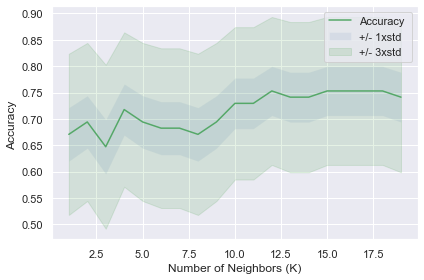

The best accuracy was with 0.7529411764705882 with k= 12


In [25]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

Use the best K value to build the K-Means model

In [26]:
k = mean_acc.argmax()+1
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.6863905325443787
Test set Accuracy:  0.7529411764705882


Use the model to predict the expected number of French restaurants for each ward

In [27]:
dfLondonVenues['restaurantFrenchPrediction'] = neigh.predict(x)
dfLondonVenues

def potential(df):
    if df['restaurantFrenchPrediction'] - df['binsFrench'] == 3: return 3
    elif df['restaurantFrenchPrediction'] - df['binsFrench'] == 2: return 2
    elif df['restaurantFrenchPrediction'] - df['binsFrench'] == 1: return 0
    else: return 0
dfLondonVenues['potential'] = dfLondonVenues.apply(potential, axis=1)
dfHighestPotential = dfLondonVenues[dfLondonVenues['potential'] > 1].sort_values('potential',ascending=False)

dfHighestPotential = dfHighestPotential[dfHighestPotential['deprivation']>0.5].sort_values(['income'])
dfHighestPotential

,ward,restaurant,restaurantFrench,park,shop,lat,long,travelZone,deprivation,income,central,distanceFromCentre,population,households,binsFrench,restaurantFrenchPrediction,potential
400,West Finchley,28,0,1,4,51.607783,-0.186547,0.727273,0.736266,0.751851,0.0,0.453550,0.189834,0.184631,0,2,2
205,Holland,24,0,1,9,51.501039,-0.207839,0.358193,0.635729,0.773136,0.0,0.312861,0.102899,0.115604,0,2,2
158,Frognal and Fitzjohns,26,1,2,11,51.553321,-0.182202,0.366021,0.934371,0.863414,0.0,0.277364,0.128964,0.134521,1,3,2
299,Queen's Gate,25,1,1,7,51.498618,-0.185434,0.181818,0.838454,0.926923,0.0,0.227145,0.117297,0.138229,1,3,2


Plot the most promising wards on the map

In [33]:
londonLat = 51.5074
londonLong = -0.1278
mapLondon = folium.Map(location=[londonLat, londonLong], zoom_start=11)

for lat, lng, ward, potential in zip(dfHighestPotential['lat'], dfHighestPotential['long'], dfHighestPotential['ward'], dfHighestPotential['potential']):
    label = ward
    label = folium.Popup(label, parse_html=True)
    colorDict = {3: 'green',2: 'yellow', 1: 'red'}
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color=colorDict[potential],
        fill=True,
        fill_color=colorDict[potential],
        fill_opacity=1,
        parse_html=False).add_to(mapLondon)
    
for lat, lng, venue in zip(dfFrench['venueLat'], dfFrench['venueLong'], dfFrench['venue']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='darkred',
        fill_opacity=1,
        parse_html=False).add_to(mapLondon)  
    
mapLondon

## Discussion

It is unsurprising that two very different analyses yield entirely different results.

The premium Jean-Claude places upon the income of nearby residents means that his method identifies the wards typically associated with fine dining, in wealthy South-West London. While these might all be fabulous places for a new French restaurant, all have a high-priced rental market to match and so operating costs would be extremely high. This might make his restaurant a reputational success, but a lacklustre source of income.

The second analysis identifies wards which have fewer than the expected number of French restaurants, given their characteristics. Opening restaurants in these areas might achieve similar success in terms of diners, but at a lower cost in terms of rent.

## Conclusion

If it is just the numbers of diners Jean-Claude is concerned by, he might open in the wealthy areas of South-West London. However, if he also seeks to maximise his profit from those diners, or share his food with more people because he can afford to offer it at a lower cost, he should further investigate the wards of:

- West Finchley
- Frognal and Fitzjohns